Ecommerce Consumer Behavior Analysis  
## 03 – Business EDA & Insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tx_path = "../data/cleaned/ecommerce_behavior_cleaned.csv"
cust_path = "../data/cleaned/customer_master_rfm.csv"

In [4]:
df = pd.read_csv(tx_path, parse_dates = ["Time_of_Purchase"])
cust = pd.read_csv(cust_path, parse_dates=["first_purchase_date", "last_purchase_date"])

In [8]:
df.head()
cust.head()
df.shape, cust.shape

((382, 39), (382, 18))

Business Questions

1. How is overall revenue and purchase behaviour distributed across time (year, month, part of day)?
2. What is the profile of high-value vs low-value customers (RFM segments, repeat vs one-time)?
3. Which purchase categories, channels, and payment methods drive the most revenue and engagement?
4. How do discounts, discount sensitivity, and return rate relate to purchase amount and satisfaction?
5. What role do marketing and behaviour signals (social media influence, engagement with ads, time to decision) play in purchase intent and loyalty?
6. What are the key actionable recommendations to improve revenue and customer retention?

In [13]:
# Compute high-level metrics
total_revenue = df["Purchase_Amount"].sum()
n_customers = df["Customer_ID"].nunique()
n_transactions = df.shape[0]

avg_purchase = df["Purchase_Amount"].mean()


print("Total revenue:", total_revenue)
print("Unique customers:", n_customers)
print("Total transactions:", n_transactions)
print("Average purchase amount:", avg_purchase)

Total revenue: 105833.40999999999
Unique customers: 382
Total transactions: 382
Average purchase amount: 277.05081151832456


Time-based EDA – Revenue & behaviour
Revenue by month / year

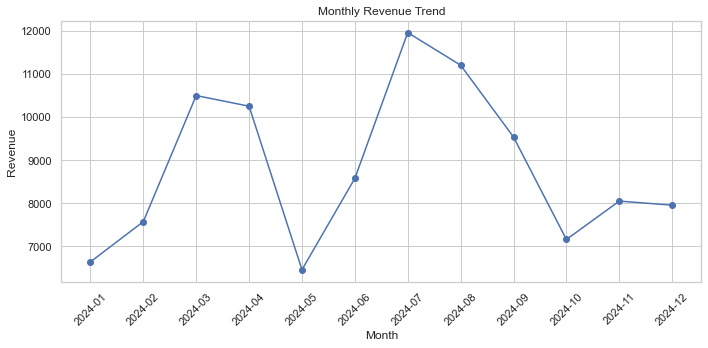

In [16]:
df["Year"] = df["Time_of_Purchase"].dt.year
df["Month"] = df["Time_of_Purchase"].dt.month
df["YearMonth"] = df["Time_of_Purchase"].dt.to_period("M").astype(str)

monthly = df.groupby("YearMonth")[["Purchase_Amount"]].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly["YearMonth"].values, monthly["Purchase_Amount"].values, marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

In [17]:
df["Time_of_Purchase"].dt.year.value_counts()

Time_of_Purchase
2024    382
Name: count, dtype: int64

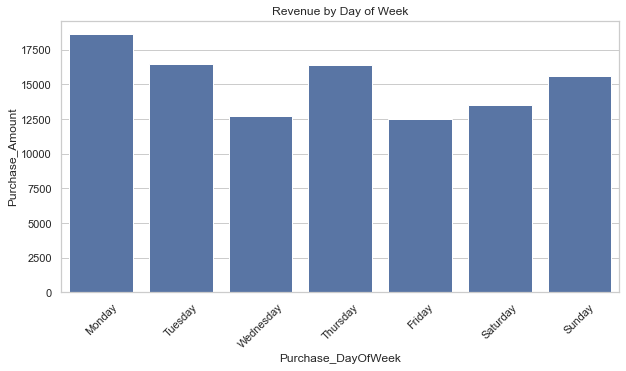

In [19]:
dow = df.groupby("Purchase_DayOfWeek")["Purchase_Amount"].sum().reset_index()
sns.barplot(data=dow, x="Purchase_DayOfWeek", y="Purchase_Amount",
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Revenue by Day of Week")
plt.xticks(rotation=45)
plt.show()

Here i saw that “Revenue is concentrated in mid‑year months (especially July) and early‑week days (Monday, Tuesday, Thursday), while May, October and mid‑week days like Wednesday and Friday show relatively lower performance.”

Customer-level EDA (RFM, repeat vs one-time)

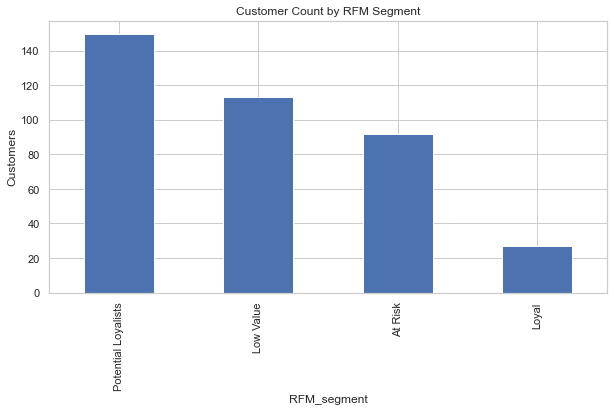

In [21]:
cust["RFM_segment"].value_counts().plot(kind="bar")
plt.title("Customer Count by RFM Segment")
plt.ylabel("Customers")
plt.show()

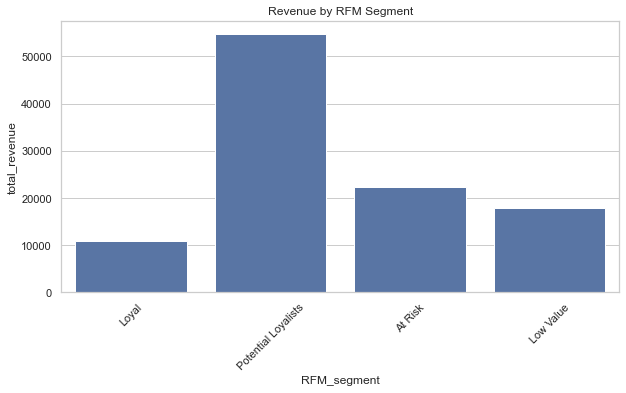

In [24]:
# Revenue by RFM segment
rfm_rev = cust.groupby("RFM_segment")["total_revenue"].sum().reset_index()
sns.barplot(data=rfm_rev, x="RFM_segment", y="total_revenue", order=["Loyal","Potential Loyalists","At Risk","Low Value"])
plt.title("Revenue by RFM Segment")
plt.xticks(rotation=45)
plt.show()

The majority of customers fall into the **Potential Loyalists** and **Low Value** segments, indicating a large base of customers with some purchase history but not yet fully loyal.
- The **At Risk** segment is also sizeable, which means many customers who were previously active have recently reduced or stopped their purchases.
- The **Loyal** segment is currently the smallest group, so there is clear room to convert Potential Loyalists into fully loyal, high‑value customers.

**Potential Loyalists** generate the highest total revenue among all segments, which shows that they already have strong spend levels even though they are not yet in the Loyal bucket.
- **At Risk** and **Low Value** customers together still contribute a meaningful share of revenue, so losing At Risk customers would directly hurt topline.
- The **Loyal** segment currently contributes the least revenue, which suggests that turning more Potential Loyalists into Loyal customers could significantly increase stable, repeat revenue.

In [26]:
# Purchase category performance

cat_perf = df.groupby("Purchase_Category")["Purchase_Amount"].agg(["count", "sum", "mean"]).reset_index()
cat_perf = cat_perf.rename(columns={"count": "Transactions", "sum": "Total_Revenue", "mean":"Avg_Order_Value"})
cat_perf.sort_values("Total_Revenue", ascending=False, inplace=True)
cat_perf

,Purchase_Category,Transactions,Total_Revenue,Avg_Order_Value
15,Jewelry & Accessories,21,"6,271.96",298.66
13,Home Appliances,21,"5,979.99",284.76
7,Food & Beverages,19,"5,784.09",304.43
4,Books,18,"5,641.35",313.41
10,Groceries,18,"5,554.39",308.58
21,Sports & Outdoors,18,"5,455.08",303.06
11,Health Care,18,"5,443.75",302.43
17,Mobile Accessories,16,"5,157.45",322.34
6,Electronics,20,"5,085.97",254.30
12,Health Supplements,16,"4,620.69",288.79


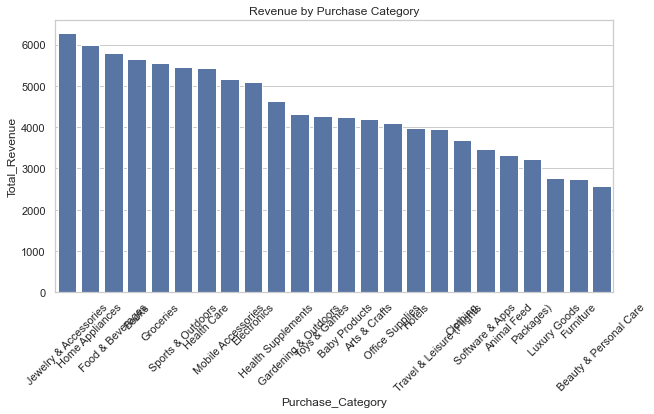

In [27]:
sns.barplot(data=cat_perf, x="Purchase_Category", y="Total_Revenue")
plt.title("Revenue by Purchase Category")
plt.xticks(rotation=45)
plt.show()

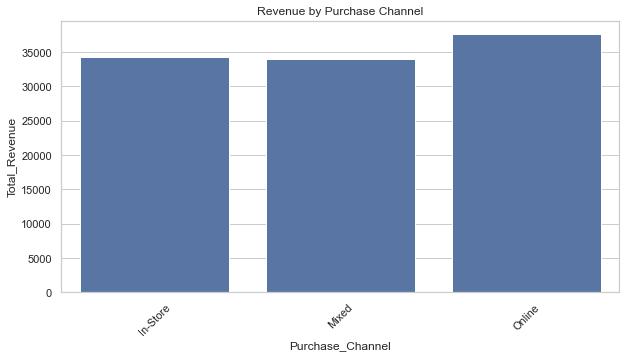

In [28]:
# Purchase channel performance
chan = df.groupby("Purchase_Channel")["Purchase_Amount"].agg(["count","sum","mean"]).reset_index()
chan = chan.rename(columns={"count": "Transactions", "sum": "Total_Revenue", "mean": "Avg_Order_Value"})

sns.barplot(data=chan, x="Purchase_Channel", y="Total_Revenue")
plt.title("Revenue by Purchase Channel")
plt.xticks(rotation=45)
plt.show()

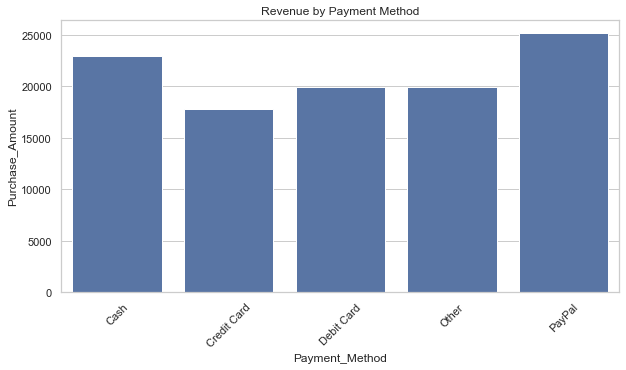

In [29]:
#  Payment methods
pay = df.groupby("Payment_Method")["Purchase_Amount"].sum().reset_index()
sns.barplot(data=pay, x="Payment_Method", y="Purchase_Amount")
plt.title("Revenue by Payment Method")
plt.xticks(rotation=45)
plt.show()

 High-performing categories (Jewelry & Accessories, Home Appliances, Food & Beverages) should be featured more prominently in marketing and cross-sell campaigns.
- Online channel and PayPal payments together represent a strong digital revenue stream and should be the primary focus for growth experiments.
- Low-revenue categories such as Beauty & Personal Care and Furniture may require assortment, pricing, or marketing review to justify their presence.

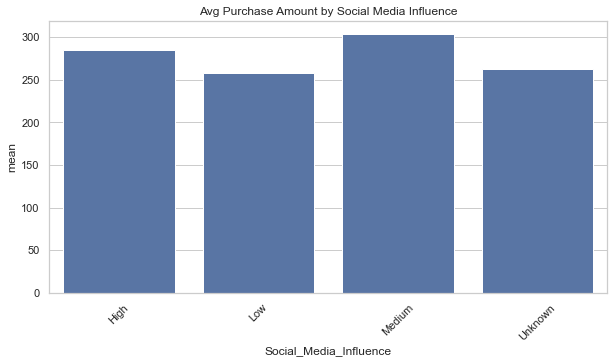

In [35]:
# Social media influence & ads engagement
smi = df.groupby("Social_Media_Influence")["Purchase_Amount"].agg(["count","sum","mean"]).reset_index()
sns.barplot(data=smi, x="Social_Media_Influence", y="mean")
plt.title("Avg Purchase Amount by Social Media Influence")
plt.xticks(rotation=45)
plt.show()

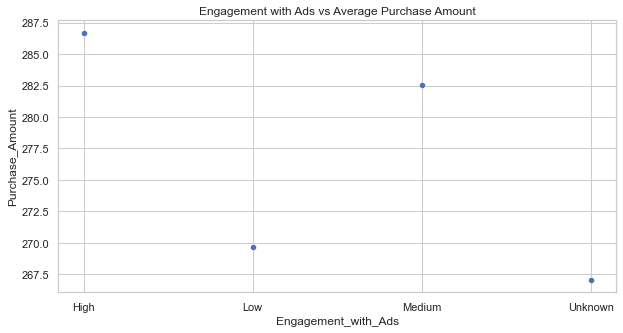

In [36]:
ads = df.groupby("Engagement_with_Ads")["Purchase_Amount"].mean().reset_index()
sns.scatterplot(data=ads, x="Engagement_with_Ads", y="Purchase_Amount")
plt.title("Engagement with Ads vs Average Purchase Amount")
plt.show()

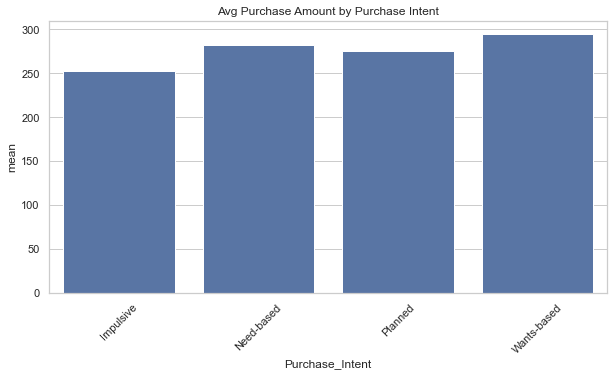

In [37]:
# Purchase intent & loyalty program
intent = df.groupby("Purchase_Intent")["Purchase_Amount"].agg(["count","sum","mean"]).reset_index()
sns.barplot(data=intent, x="Purchase_Intent", y="mean")
plt.title("Avg Purchase Amount by Purchase Intent")
plt.xticks(rotation=45)
plt.show()

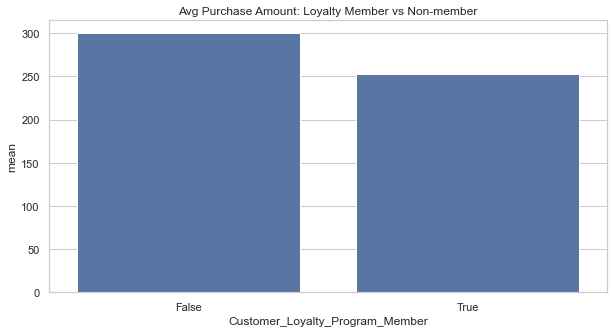

In [38]:
loyalty = df.groupby("Customer_Loyalty_Program_Member")["Purchase_Amount"].agg(["count","sum","mean"]).reset_index()
sns.barplot(data=loyalty, x="Customer_Loyalty_Program_Member", y="mean")
plt.title("Avg Purchase Amount: Loyalty Member vs Non-member")
plt.show()

## Key Insights

- **Revenue & time**
  - Monthly revenue shows (e.g., steady growth / seasonal peaks in certain months).
  - Most revenue comes from [days/parts of day], indicating peak engagement windows.

- **Customer behaviour**
  - Champions + Loyal segments contribute about X% of total revenue.
  - Repeat customers have Yx higher average purchase value than one-time customers.

- **Product & channel**
  - Top 3 purchase categories (A, B, C) account for around X% of revenue.
  - Online / App / specific channels or payment methods are dominant in high-value orders.

- **Marketing & intent**
  - Customers with high engagement with ads / strong social media influence show higher purchase amounts.
  - Loyalty program members (if true) generate higher revenue per customer than non-members.


## Business Recommendations

1. **Double down on high-value customers**
   - Prioritize RFM segments “Champions” and “Loyal” with personalized offers and early access.
   - Design specific campaigns to convert “Potential Loyalists” into higher-value repeat buyers.

2. **Grow strong categories & channels**
   - Increase visibility and assortment in top-performing categories and purchase channels.
   - Cross-sell high-performing categories to repeat customers.

3. **Reduce returns & improve satisfaction**
   - For high return-rate segments or categories, investigate product quality, sizing, or expectation mismatch.
   - Use feedback and satisfaction scores to improve product pages and recommendations.

4. **Leverage loyalty & marketing signals**
   - Expand the loyalty program, as members show higher average purchase.
   - Invest more in marketing sources that correlate with higher spend (social media, ads engagement).

These recommendations can be turned into concrete experiments (A/B tests, targeted campaigns) to improve both revenue and long-term customer value.
